# Chapter 7: Ensemble Learning and Random Forests

### Topics:
- Voting Classifiers
- Bagging and Pasting
    - Bagging and Pasting in Scikit-Learn
    - Out-of-Bag Evaluation
- Random Patches and Random Subspaces
- Random Forests:
    - Extra Trees
    - Feature Importance
- Boosting
    - Adaboost
    - Gradient Boosting
- Stacking

In [24]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import matplotlib.pyplot as plt

# Seaborn background
plt.style.use('seaborn-whitegrid')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Intro

Suppose you ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of predictors
is called an *ensemble*; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an *Ensemble method*.

## Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
classifier, a K-Nearest Neighbors classifier, and perhaps a few more. 

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a *hard voting* classifier.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a *weak learner* (meaning
it does only slightly better than random guessing), the ensemble can still be a
*strong learner* (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


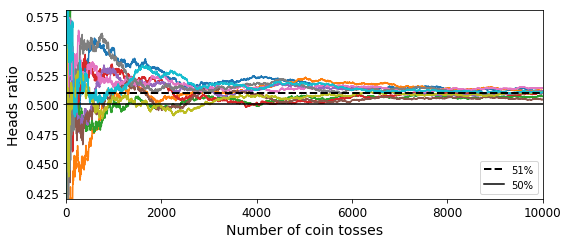

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

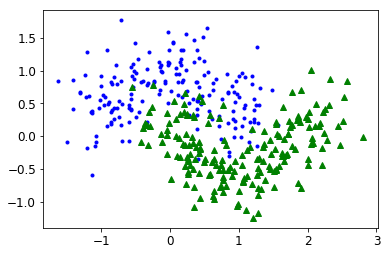

In [5]:
# Visualizing the dataset
plt.plot(X_train[:,0][y_train==0], X_train[:,1][y_train==0], "b.")
plt.plot(X_train[:,0][y_train==1], X_train[:,1][y_train==1], "g^")

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)  # Rafa: why are we setting a random seed for log reg? This is a deterministic algo
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators = [("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], 
    voting = "hard"
)

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


C:\Users\marino.re\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Soft Voting

If all classifiers are able to estimate class probabilities (i.e., they have a **predict_proba()**
method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called *soft
voting*. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities.


##### Rafa Note:
In other words. "Hard Voting" refers to a discrete majority decision voting among classifiers. Whereas "soft voting" refers to an average of probabilities returned by each classifier.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)  # Rafa: why are we setting a random seed for log reg?
rnd_clf = RandomForestClassifier(random_state=42)
# SVC does not return probabilities by default. Set probability=True
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators = [("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], 
    voting = "soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


C:\Users\marino.re\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed with replacement, this method is called *bagging* (short for
*bootstrap aggregating*). When sampling is performed without replacement, it is called
*pasting*.

In [11]:
X_train.shape

(375, 2)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# n_estimators refers to the number of decision trees to be fit
# bootstrap=True implies BAGGING, i.e. bootstrap aggregating. If bootstrap=False then it'll be Pasting
# n_jobs = -1. Tell SciKit Learn the number of CPU cores to use for training and prediction. '-1' = use all available cores
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, 
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42
)

In [13]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [14]:
y_pred = bag_clf.predict(X_test)

#### Note:
The BaggingClassifier automatically performs soft voting
instead of hard voting if the base classifier can estimate class probabilities
(i.e., if it has a **predict_proba()** method), which is the case
with Decision Trees classifiers.

### Comparing a Single Decision Tree vs a Decision Tree with Bagging

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


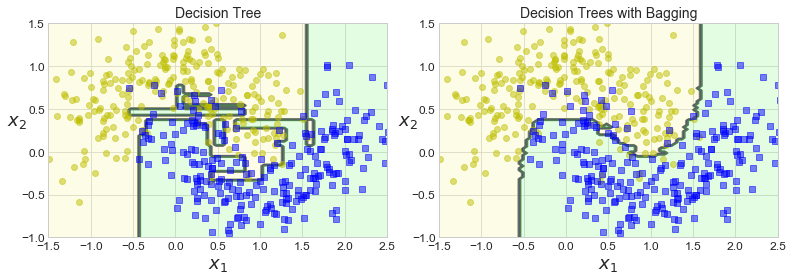

In [25]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6 The remaining 37% of the training instances that are not
sampled are called *out-of-bag (oob)* instances. Note that they are not the same 37%
for all predictors.

**Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set or cross-validation. You
can evaluate the ensemble itself by averaging out the oob evaluations of each predictor**.

In Scikit-Learn, you can set *oob_score=True* when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, 
                           bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)

bag_clf.fit(X_train, y_train)

In [ ]:
bag_clf.oob_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

The oob decision function for each training instance is also available through the
oob_decision_function_ variable. In this case (since the base estimator has a pre
dict_proba() method) the decision function returns the class probabilities for each
training instance. For example, the oob evaluation estimates that the second training
instance has a 60.6% probability of belonging to the positive class (and 39.4% of
belonging to the positive class):

In [ ]:
bag_clf.oob_decision_function_[0:3,:]

## Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is controlled
by two hyperparameters: max_features and bootstrap_features. They work
the same way as max_samples and bootstrap, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the
input features.

This is particularly useful when you are dealing with high-dimensional inputs (such
as images). Sampling both training instances and features is called the **Random
Patches method**. Keeping all training instances (i.e., bootstrap=False and max_sam
ples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_fea
tures smaller than 1.0) is called the **Random Subspaces method.**

# Random Forests

In [ ]:
# Visualizing the dataset
plt.plot(X_train[:,0][y_train==0], X_train[:,1][y_train==0], "b.")
plt.plot(X_train[:,0][y_train==1], X_train[:,1][y_train==1], "g^")

As we have discussed, a Random Forest9 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and passing
it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees () (similarly, there is
a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using
all available CPU cores:
    
### Note:
The BaggingClassifier class remains useful if you want a bag of something other than Decision Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators: number of trees to be trained
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

In [ ]:
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), **it
searches for the best feature among a random subset of features**. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model.

# Feature Importance in Decision Trees

Lastly, if you look at a single Decision Tree, important features are likely to appear
closer to the root of the tree, while unimportant features will often appear closer to
the leaves (or not at all). It is therefore possible to get an estimate of a feature’s importance
by computing the **average depth at which it appears across all trees in the forest**.
Scikit-Learn computes this automatically for every feature after training. You can
access the result using the feature_importances_ variable.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

In [ ]:
iris.keys()
# type(iris)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

In [ ]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    # print(name, "%.2f" % score)
    print( name, "{0:.2f}".format(score))

In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({"Feature": iris['feature_names'],
                                   "Importance": rnd_clf.feature_importances_})
# sort_values is not an inplace operation by default. inplace=F/T
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

### Interpretation:

It seems that the most important features are the petal length (45%) and width (43%), while sepal length and width are
rather unimportant in comparison (10% and 3%, respectively). 

Rafa: How do you go from average depth of each feature to a % measure?

# Boosting

*Boosting* (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its predecessor.
There are many boosting methods available, but by far the most popular are
AdaBoost[13] (short for *Adaptive Boosting*) and *Gradient Boosting*. Let’s start with Ada‐
Boost.

[13] “A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting,” Yoav Freund,
Robert E. Schapire (1997).

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by Ada‐
Boost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on

Equation 7-1. Weighted error rate of the jth predictor

$$ \Large r_j = \frac{ {\Sigma_i^m w^{(i)}}_{s.t. \ \hat{y}_j^{(i)} \ne y^{(i)} }} { \Sigma_i^m w^{(i)} } \\
\small \text{(i.e. summation over misclasified instances)}  $$

Equation 7-2. Predictor weight

$$ \large \alpha_j = \eta \ log \frac{1 - r_j}{r_j}     $$

Equation 7-3. Weight update rule

*for i = 1,2,..., m *

$$ \large w^{(i)} \leftarrow 
\begin{cases}
  w^{(i)} = w^{(i)} & \text{if }\hat{y}_j^{(i)} = y^{(i)}\\    
  w^{(i)} = w^{(i)} exp(\alpha_j) & \text{if }\hat{y}_j^{(i)} \ne y^{(i)}\\   
\end{cases}  $$

### Final AdaBoost Prediction Rule:

$$ \large \hat{y}(x) = \mathop{\arg\max}\limits_x \Sigma_{j=1}^N \alpha_j \ \ \ \small (\hat{y}_j(x)=k)
\\ \small \text{(i.e. summ. over predictors that output k)}  $$




In [20]:
## Adaboost on Scikit learn

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm = "SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

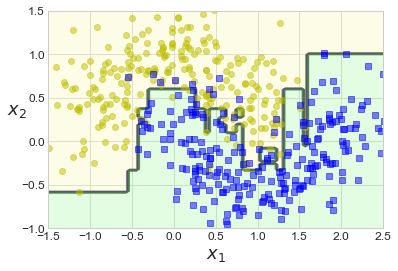

In [27]:
plt.style.use('seaborn-whitegrid')

plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


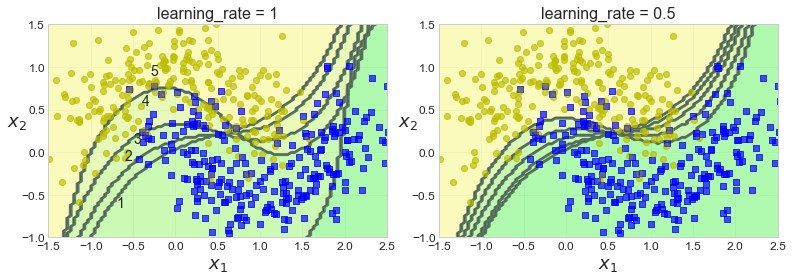

In [28]:
plt.style.use('seaborn-whitegrid')

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

### Notes on AdaBoost Overfitting

If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing
the base estimator.

# Gradient Boosting

Another very popular Boosting algorithm is *Gradient Boosting*. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the *residual
errors* made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predictors
(of course Gradient Boosting also works great with regression tasks). This is
called ***Gradient Tree Boosting***, or ***Gradient Boosted Regression Trees*** (GBRT). First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training
set):

In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)  # 3 times x, to the square, times gaussian noise

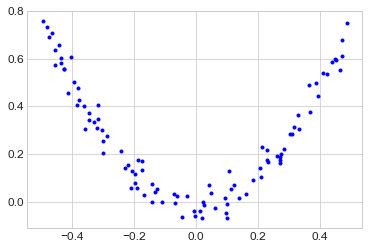

In [32]:
# Visualizing the data

plt.plot(X, y, "b.")

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [34]:
# Training a 2nd DecisionTree on the residual errors made by the first predictor
# i.e. the residual errors become the new target variable

y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
# Training a 3rd DecisionTree on the residual errors made by the 2nd predictor

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)  # instantiate it
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [36]:
# New observation
# Remember that new observations need to be numpy arrays
X_new = np.array([[0.8]])

In [ ]:
# Making predictions

y_pred = sum(tree)